# Validation

In [28]:
import sys
sys.path.append("../")

from __init__ import *
from data_tools import *
from testing import *

## Calculating Tau and Characteristing Noise

The first thing to note is the Tau value of our data. Let us choose an event, take a 40.96 $\mu s$ time slice, calculate an FFT and also observe the associated truth data.

In [2]:
def generate_noise(T=T, samples=1000, resistance=1, B=B, k=k):
    """Generates noise with a given temperature and resistance

    Args:
        T (float, optional): Temperature in Kelvin (K). Defaults to T.
        samples (int, optional): Number of samples to generate. Defaults to 1000.
        resistance (_type_, optional): Resistance in Ohms. Defaults to resistance.
        B (_type_, optional): Bandwidth. Defaults to B.
        k (_type_, optional): Boltzmann Constant. Defaults to k.

    Returns:
        noise_dist (arr): Noise distribution
    """
    
    P_noise = k * T * B   # Noise Power (W) 

    noise_dist = np.sqrt(resistance * 0.5) * np.random.normal(0, np.sqrt(P_noise), samples) # Noise distribution

    # plt.hist(noise_dist, bins=100)
    # plt.show()

    return noise_dist # Returns the noise distribution

signal1 has a Waveguide impedance [Ohms] equal to 496.1709043911709 Ohms
Time slice is 40.96  micro seconds
With a total number of  20481 Bins


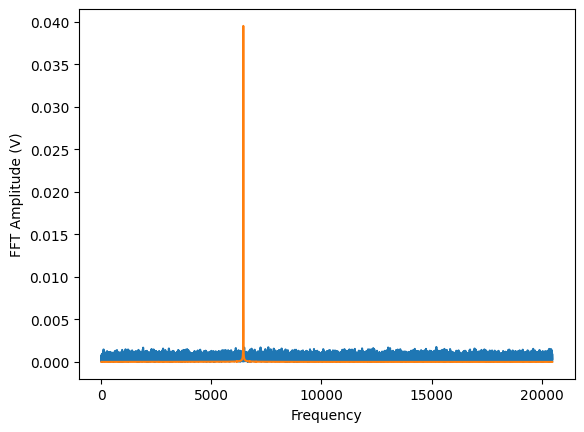

(0.027467038912520746+0.01020252485640787j)


In [3]:
file = path + '90harmonic.h5'
index = 0

strings, attributes, attributes_values = get_attributes(file)

impedance = attributes_values[index][9]

print(strings[index], "has a", attributes[9], 'equal to', impedance, 'Ohms')

signal = get_signal(file, strings[index])

no_samples = 40960 # For a 40.96 us time slice

signal_fft = np.fft.rfft(signal[:no_samples]) * 16 # Account for power issues, 16 is a scaling factor

print('Time slice is', no_samples * 1e-9 * 1e6, ' micro seconds')
print('With a total number of ', len(np.abs(signal_fft)), 'Bins')

# Noise FFT
noise = generate_noise(5, no_samples, resistance = impedance)

noise_fft = np.fft.rfft(noise)

plt.plot(np.abs(noise_fft))
plt.plot(np.abs(signal_fft))
plt.ylabel('FFT Amplitude (V)')
plt.xlabel('Frequency')
plt.show()

# n_fft = np.abs(noise_fft)**2
# s_fft = np.abs(signal_fft)**2


# plt.plot(s_fft/impedance)
# plt.plot(n_fft/impedance)
# plt.ylabel('Power (A^2/R)')
# plt.xlabel('Frequency')
# plt.show()


sig_val = np.max(abs(signal_fft))
print(np.max(signal_fft))

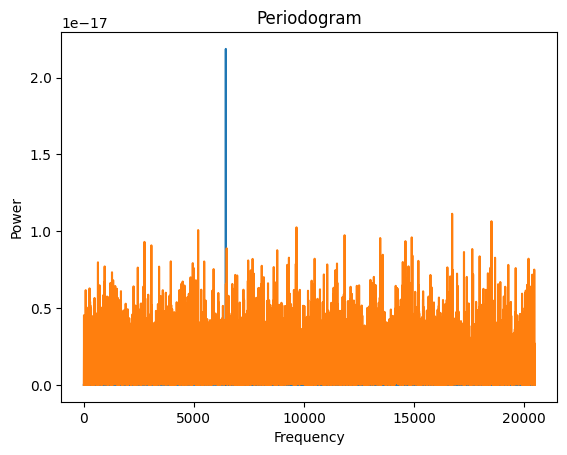

In [4]:
# print(np.max(np.abs(signal_fft)))

# print(np.max(np.abs(signal_fft))/impedance)


# print(np.max(np.abs(signal_fft)**2))

# print(np.max(np.abs(signal_fft)**2)/impedance)


sig_vals = scipy.signal.periodogram(signal[:no_samples], fs=1e9, window='hann', nfft=no_samples, return_onesided=True, scaling='spectrum')
nois_vals = scipy.signal.periodogram(noise, fs=1e9, window='hann', nfft=no_samples, return_onesided=True, scaling='spectrum')

plt.title("Periodogram")
plt.plot(sig_vals[1]/impedance)
plt.plot(nois_vals[1]/impedance)
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.show()


Tau is defined as 
$$ \tau = kTBR / N_{FFT} $$

In [5]:
R = attributes_values[0][9]
N_fft = len(np.abs(signal_fft))

tau = k * T * B * R / N_fft
print(tau)

tau = tau

8.357939652114349e-16


## Validating Rayleigh Distributions

Testing a single Rayleigh bin with manual and scipy implementation (with scaling)

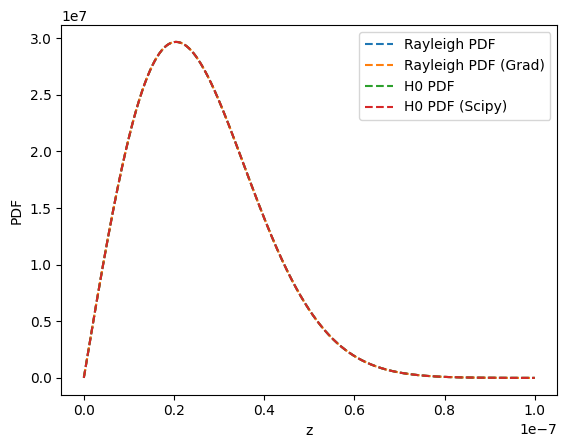

KS Test Results:
Comparison 1 vs 2: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 1 vs 3: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 1 vs 4: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 2 vs 3: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 2 vs 4: KS Statistic = 0.00200000, p-value = 1.00000000
Comparison 3 vs 4: KS Statistic = 0.00000000, p-value = 1.00000000


/Users/nathan/miniforge3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [6]:
z_values = np.linspace(0, 1e-7, 1000)
N_bin = 1

# No Scipy 
null_dist = H0_PDF(z_values, tau, 1, scipy=False)

# Scipy
null_dist_scipy = H0_PDF(z_values, tau, 1, scipy=True) 

# Numerical Differentiation
ray_cdf_dist = rayleigh_CDF(z_values, tau, N_bin=1)
ray_pdf_dist = numerical_derivative_rayleigh_CDF(z_values, tau, N_bin, delta=1e-10)

# Numerical Differentiation pt.2
ray_pdf_dist_grad = np.gradient(ray_cdf_dist, z_values)

plt.plot(z_values, ray_pdf_dist, label='Rayleigh PDF', linestyle='--')
plt.plot(z_values, ray_pdf_dist_grad, label='Rayleigh PDF (Grad)', linestyle='--')

plt.plot(z_values, null_dist, label='H0 PDF', linestyle='--')
plt.plot(z_values, null_dist_scipy, label='H0 PDF (Scipy)', linestyle='--')
plt.legend()
plt.xlabel('z')
plt.ylabel('PDF')
plt.show();

# distributions = [pdf_dist, pdf_dist_grad, null_dist, null_dist_scipy]

# for dist in distributions:
#     print(scipy.integrate.trapezoid(dist, z_values))

# KS Test
distributions = [ray_pdf_dist, ray_pdf_dist_grad, null_dist, null_dist_scipy]

KS_test(distributions);

## Aside: Testing Rician with Log Space Approach

My experiments with trying to reproduce a manually coded Rician CDF and comparing with a scaled Scipy Rice Function have led to a few conclusions. The main one being that numerical stability is difficult to overcome. As we use smaller tau values (approaching our own tau of 1e-16) and decreasing z_ranges to narrow in on the area of interest (the curve of the CDF), we start to see divergence between my custom method (using log space) and the scipy implementation)

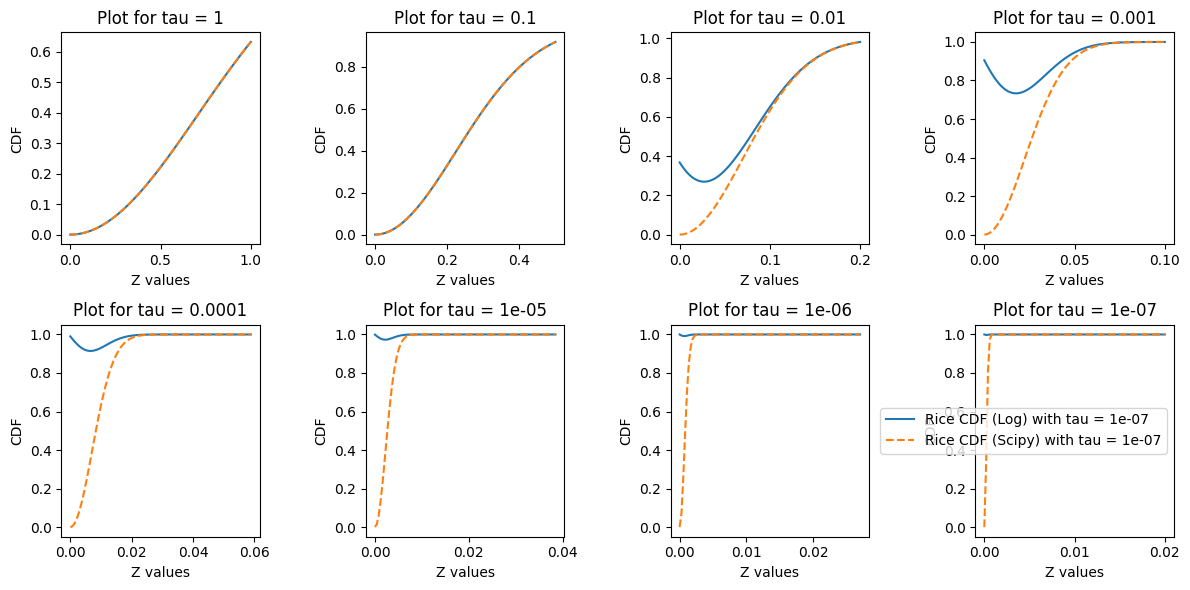

In [7]:
z_values = np.linspace(0, 1, 1000)
N_bin = 1
x_S = 1e-6
tau_rice = 1

tau_list = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# Create a 2x4 grid of subplots (8 subplots in total)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the axes array to make iteration easier
axes = axes.flatten()

for i, tau_rice in enumerate(tau_list):
    ax = axes[i]
    
    z_values= np.linspace(0, 1/((i**2)+1), 100)
    
    # Calculate your rice distributions
    log_rice_dist = [rice_cdf_log_space(z, tau_rice, x_S) for z in z_values]
    rice_cdf_dist_scipy = rice_CDF(z_values, tau_rice, x_S)

    # Labels for the plots
    label_log = 'Rice CDF (Log) with tau = ' + str(tau_rice)
    label = 'Rice CDF (Scipy) with tau = ' + str(tau_rice)
    
    # Plot the two distributions on the corresponding subplot
    ax.plot(z_values, log_rice_dist, label=label_log)
    ax.plot(z_values, rice_cdf_dist_scipy, label=label, linestyle='--')
    
    # Set the title and labels
    ax.set_title(f'Plot for tau = {tau_rice}')
    ax.set_xlabel('Z values')
    ax.set_ylabel('CDF')

    # Add a legend
    
ax.legend()

# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Show the plots
plt.show()

One thing that we can be sure of is that when 

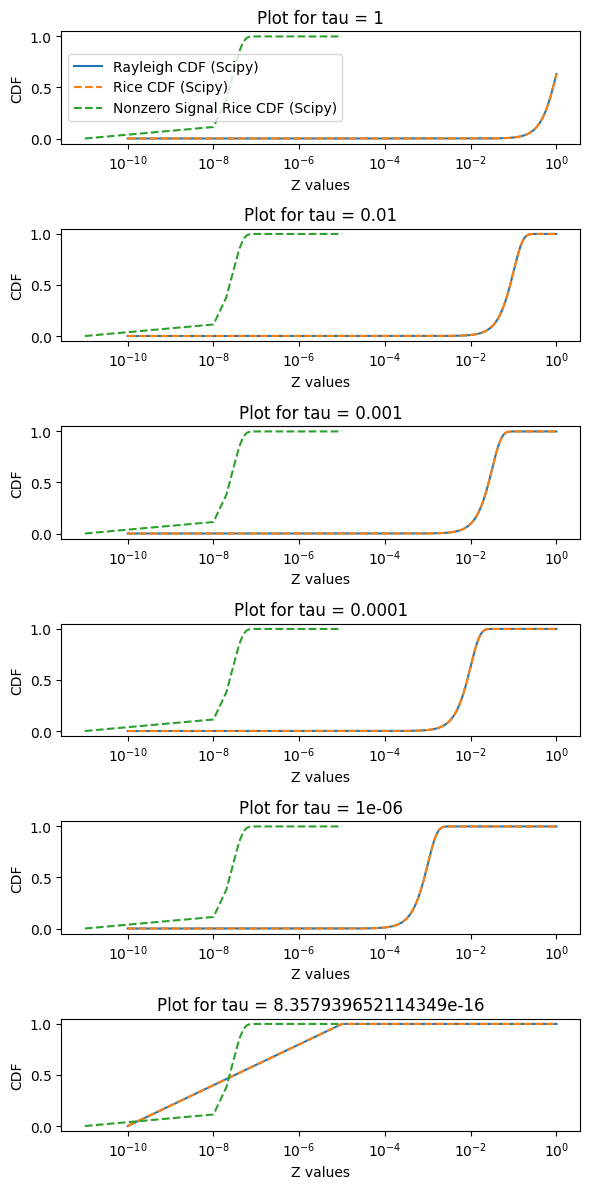

In [8]:
N_bin = 1
x_S = sig_val
tau_rice = 1

tau_list = [1, 1e-2, 1e-3, 1e-4, 1e-6, 8.357939652114349e-16]

# Create a 2x4 grid of subplots (8 subplots in total)
fig, axes = plt.subplots(6, 1, figsize=(6, 12))

# Flatten the axes array to make iteration easier
axes = axes.flatten()

for i, tau_rice in enumerate(tau_list):
    ax = axes[i]
    
    z_values= np.linspace(1e-10, 1, 100000)
    smaller_z_values = np.linspace(1e-11, 1e-5, 1000)
    
    # Calculate your rice distributions
    rice_cdf = rice_CDF(z_values, tau_rice, 0)
    rice_cdf_nonzero = rice_CDF(smaller_z_values, tau, x_S)
    
    ray_cdf = rayleigh_CDF(z_values, tau_rice, N_bin=1)


    # Labels for the plots
    label_rice = 'Rice CDF (Scipy)'
    label_ray = 'Rayleigh CDF (Scipy)'
    label_rice_nonzero = 'Nonzero Signal Rice CDF (Scipy)'
  
    
    # Plot the two distributions on the corresponding subplot
    ax.plot(z_values, ray_cdf, label=label_ray)
    ax.plot(z_values, rice_cdf, label=label_rice, linestyle='--')
    ax.plot(smaller_z_values, rice_cdf_nonzero, label=label_rice_nonzero, linestyle='--')
    
      
    if i ==0:
            
        ax.legend()
    
    ax.set_xscale('log')
    
    # Set the title and labels
    ax.set_title(f'Plot for tau = {tau_rice}')
    ax.set_xlabel('Z values')
    ax.set_ylabel('CDF')

    # Add a legend


# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Show the plots
plt.show()


# rice_cdf = rice_CDF(z_values, tau, 0)
# ray_cdf = rayleigh_CDF(z_values, tau, N_bin=1)



# plt.plot(z_values, rice_cdf, label='Rice CDF')
# plt.plot(z_values, ray_cdf, label='Rayleigh CDF', linestyle='--')
# plt.plot(z_values, rice_cdf_nonzero, label='Rice CDF (Non-Zero)', linestyle='--')
# plt.legend()
# plt.show()

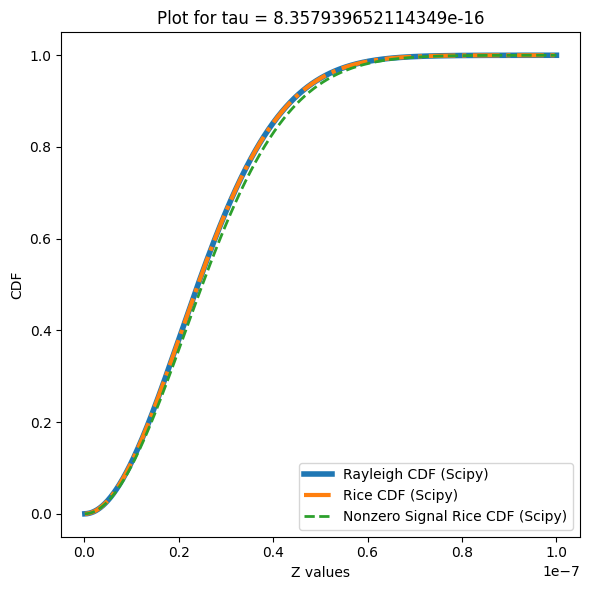

In [9]:
N_bin = 1
x_S = sig_val * 10

tau = 8.357939652114349e-16

tight_z_values = np.linspace(1e-10, 1e-7, 100000)

# Calculate your rice distributions
rice_cdf = rice_CDF(tight_z_values, tau, 0)
rice_cdf_nonzero = rice_CDF(tight_z_values, tau, x_S)

ray_cdf = rayleigh_CDF(tight_z_values, tau, N_bin=1)


# Labels for the plots
label_rice = 'Rice CDF (Scipy)'
label_ray = 'Rayleigh CDF (Scipy)'
label_rice_nonzero = 'Nonzero Signal Rice CDF (Scipy)'

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Plot the two distributions on the corresponding subplot
ax.plot(tight_z_values, ray_cdf, label=label_ray, lw=4)
ax.plot(tight_z_values, rice_cdf, label=label_rice, linestyle='-.', lw=3)
ax.plot(tight_z_values, rice_cdf_nonzero, label=label_rice_nonzero, linestyle='--', lw=2)

    

# ax.set_xscale('log')

# Set the title and labels
ax.set_title(f'Plot for tau = {tau}')
ax.set_xlabel('Z values')
ax.set_ylabel('CDF')
ax.legend()

    # Add a legend


# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Show the plots
plt.show()


# rice_cdf = rice_CDF(z_values, tau, 0)
# ray_cdf = rayleigh_CDF(z_values, tau, N_bin=1)



# plt.plot(z_values, rice_cdf, label='Rice CDF')
# plt.plot(z_values, ray_cdf, label='Rayleigh CDF', linestyle='--')
# plt.plot(z_values, rice_cdf_nonzero, label='Rice CDF (Non-Zero)', linestyle='--')
# plt.legend()
# plt.show()

Testing a single Rician bin with manual and scipy implementation (with scaling)

## Computing F1

The first thing we should do is 

So now we will take 2 bins. One scenario where we assume both to be noise, one where there is a realistic signal in one and noise in the other and a final one consisting of two signal bins.

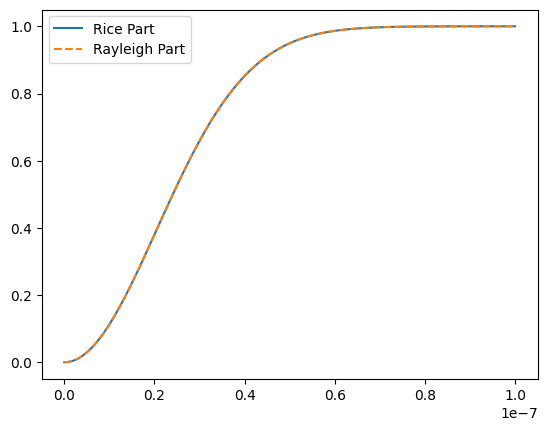

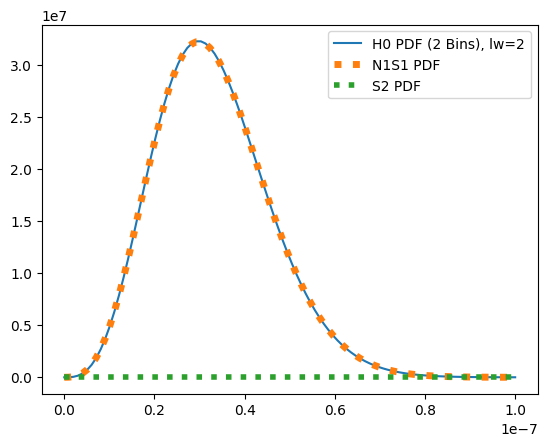

KS Test Results:
Comparison 1 vs 2: KS Statistic = 0.10000000, p-value = 0.30659649
Comparison 1 vs 3: KS Statistic = 0.99900000, p-value = 0.00000000
Comparison 2 vs 3: KS Statistic = 1.00000000, p-value = 0.00000000


In [22]:
N_bin = 2
x_S = [sig_val, sig_val]
x_k = sig_val
z_values = np.linspace(0, 1e-7, 100)

## Noisy 
null_dist_scipy_2bin = H0_PDF(z_values, tau, N_bin, scipy=True) 

## N1S1
rice_part = rice_CDF(z_values, tau, x_k)
ray_part = rayleigh_CDF(z_values, tau, N_bin=1)
N1S1_pdf_dist = np.gradient(rice_part * ray_part, z_values)


######## CDF Plots ########
plt.figure()
plt.plot(z_values, rice_part, label='Rice Part')
plt.plot(z_values, ray_part, label='Rayleigh Part', linestyle='--')
plt.legend()
plt.show()


## S2
# result_container = np.zeros(shape=(len(x_S),len(z_values)))
# for i in range(len(x_S)):
#     result = rice_CDF(z_values, tau, x_S[i])
#     result_container[i] = result
        
# result_product = np.prod(result_container, axis=0)

result_product = np.zeros(len(z_values))
for i in range(len(x_S)):
    result_product *= rice_CDF(z_values, tau, x_S[i])


signal_pdf = np.gradient(result_product, z_values)


# Plotting
plt.plot(z_values, null_dist_scipy_2bin, label='H0 PDF (2 Bins), lw=2')
plt.plot(z_values, N1S1_pdf_dist, label='N1S1 PDF', linestyle=':', lw=5)
plt.plot(z_values, signal_pdf, label='S2 PDF', linestyle='dotted', lw=4)
plt.legend()
plt.show()

# Testing
distributions = [null_dist_scipy, N1S1_pdf_dist, signal_pdf]

# print("Integrals of the PDFs")
# get_integral(distributions, z_values)

print("======================")

KS_test(distributions);

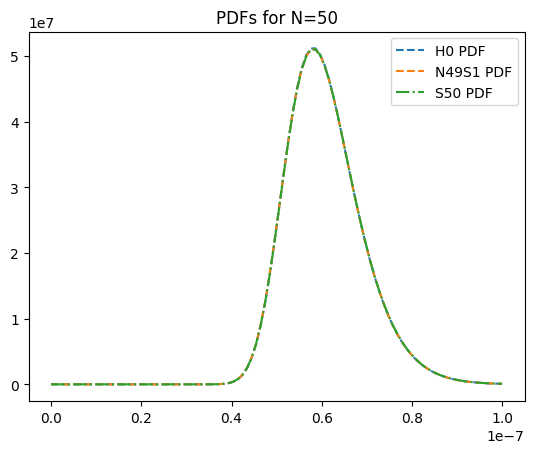

KS Test Results:
Comparison 1 vs 2: KS Statistic = 0.34900000, p-value = 0.00000000
Comparison 1 vs 3: KS Statistic = 0.34900000, p-value = 0.00000000
Comparison 2 vs 3: KS Statistic = 0.01000000, p-value = 1.00000000


In [24]:
N_bin = 50
x_S = [sig_val] * N_bin
x_k = sig_val
z_values = np.linspace(0, 1e-7, 100)

## Noisy 
null_dist_scipy_2bin = H0_PDF(z_values, tau, N_bin, scipy=True) 

## N1S1
rice_part = rice_CDF(z_values, tau, x_k)
ray_part = rayleigh_CDF(z_values, tau, N_bin=N_bin-1)
N1S1_pdf_dist = np.gradient(rice_part * ray_part, z_values)

## S3
# result_container = np.zeros(shape=(len(x_S),len(z_values)))
# for i in range(len(x_S)):
#     result = rice_CDF(z_values, tau, x_S[i])
#     result_container[i] = result
#     # print(result_container)
        
# result_product = np.prod(result_container, axis=0)

result_product = np.ones(len(z_values))
for i in range(len(x_S)):
    result_product *= rice_CDF(z_values, tau, x_S[i])

signal_pdf = np.gradient(result_product, z_values)

# Plotting
title = 'PDFs for N=' + str(N_bin)
plt.title(title)
plt.plot(z_values, null_dist_scipy_2bin, label='H0 PDF', linestyle='--')
plt.plot(z_values, N1S1_pdf_dist, label='N49S1 PDF', linestyle='--')
plt.plot(z_values, signal_pdf, label='S50 PDF', linestyle='-.')
plt.legend()
plt.show()

# Testing
distributions = [null_dist_scipy, N1S1_pdf_dist, signal_pdf]

# print("Integrals of the PDFs")
# get_integral(distributions, z_values)

print("======================")

KS_test(distributions);

Now a larger dummy test

In [33]:
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
arr_1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

arr_3 = [arr, arr_1]
np.prod(arr_3, axis=0)

array([  1,   4,   9,  16,  25,  36,  49,  64,  81, 100])

Real data test for all the different pitch angles. 

# Producing Realistic PDFs

In [29]:
# Calculating Background CDF 
def background_cdf(x, N, var):
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N)


# Calculating Background CDF with N_sample (number of bins) taken into account
def background_cdf_awk(x, n_signal, n_sample, var):
    
    N = n_sample - ak.to_numpy(n_signal)
    
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N[:, np.newaxis])

def rician_pdf(x, var, loc_val):
    
    x = x[np.newaxis, :]
    loc_val = loc_val[:, np.newaxis]
    
    return x * np.exp( -1 * (x ** 2 + loc_val ** 2) / var ) * special.iv(0, x * 2 * loc_val / var)

def cdf_from_pdf(x, pdf):
    
    cdf = np.zeros((pdf.shape[0], x.size))
    for i in range(x.size):
        
        cdf[:, i] = np.trapz(pdf[:, 0:i+1], x[0:i+1], axis=-1)
        
    return cdf

def combine_batch_cdf(cdf, counts):
    
    count = 0
    cdf_ak = []
    for n in counts:
        cdf_ak.append(cdf[count:count+n, :])
        count+=n
    cdf_ak = ak.Array(cdf_ak)
        
    return ak.to_numpy(ak.prod(cdf_ak, axis=1))

def get_spectra_peaks(freq_spectra, threshold):
    
    peaks = []
    for i in range(freq_spectra.shape[0]):
        i_peak_inds = np.where(abs(freq_spectra[i, :]) > threshold)[0]
        i_peaks = abs(freq_spectra[i, i_peak_inds])

        peaks.append(list(i_peaks))
    
    return ak.Array(peaks)
    
def generate_signal_cdf(peaks, x, var, n_sample, batchsize=1000):
    
    peak_counts = ak.num(peaks, axis=1)
    num_spectra = ak.num(peaks, axis=0)
    
    spectra_inds = np.arange(0, num_spectra, 1)
    combined_cdf = np.zeros((num_spectra, x.size))
    
    for i, spectra_batch in enumerate(np.array_split(spectra_inds, num_spectra//batchsize)):
        
        batch_peaks = peaks[spectra_batch]
        batch_counts = ak.num(batch_peaks, axis=1)
        flat_batch_peaks = ak.to_numpy(ak.flatten(batch_peaks))
        
        batch_pdf = rician_pdf(x, var, flat_batch_peaks)
        batch_norm = 1/np.trapz(batch_pdf, x, axis=-1)
        batch_pdf = batch_norm[:, np.newaxis] * batch_pdf
        
        batch_cdf = cdf_from_pdf(x, batch_pdf)
        batch_cdf = combine_batch_cdf(batch_cdf, batch_counts)

        combined_cdf[spectra_batch, :] = batch_cdf * background_cdf_awk(x, batch_counts, n_sample, var)
        
        if i % 5 == 4:
            print(f'{i + 1} / {num_spectra//batchsize}')
            
    return combined_cdf




R, Nch, kb, bw, Nsamp, T=496.1709043911709, 1, 1.38e-23, 500e6, 250, 5

# R = Impedance
# Nch = No. of channels
# kb = Boltzmann constant
# Nsamp = Number of Bins? 
# T = Temperature (Kelvin)

# noise power
n_pwr = kb * T * bw

# noise variance single channel, time-domain (tau_1t)
tau_1t = n_pwr * R
# noise variance single channel, freq-domain (tau_1f)
tau_1f = tau_1t / Nsamp
# noise variance sixty channel sum, time-domain (tau_60t)
tau_60t = tau_1t * Nch
# noise variance sixty channel sum, freq-domain (tau_60f, this is the noise variance in the paper)
tau_60f = tau_60t / Nsamp

# single-channel complex wgn with total variance tau_1t
rng = np.random.default_rng()
noise_1t = rng.multivariate_normal([0,0], np.eye(2) * tau_1t/2, Nsamp) # variance is divided by two for correct total variance.
noise_1t = noise_1t[:,0] + 1j * noise_1t[:,1]

# sixty-channel complex wgn. each channel has total variance tau_1t
noise_60t = rng.multivariate_normal([0,0], np.eye(2) * tau_1t/2, Nsamp*Nch) # variance is divided by two for correct total variance.
noise_60t = noise_60t[:,0] + 1j * noise_60t[:,1]
noise_60t = noise_60t.reshape((Nch, Nsamp))

print('1 Channel, Time-domain')
print(f'The single-channel time-domain noise variance is --- {tau_1t}')
print(f'The single-channel time-domain sample variance is --- {np.mean(abs(noise_1t)**2)}\n')

noise_1f = np.fft.fft(noise_1t, norm='forward')

print('1 Channel, Freq-domain')
print(f'The single-channel freq-domain noise variance is --- {tau_1f}')
print(f'The single-channel freq-domain sample variance is --- {np.mean(abs(noise_1f)**2)}\n')

1 Channel, Time-domain
The single-channel time-domain noise variance is --- 1.71178962014954e-11
The single-channel time-domain sample variance is --- 1.8792278335568182e-11

1 Channel, Freq-domain
The single-channel freq-domain noise variance is --- 6.84715848059816e-14
The single-channel freq-domain sample variance is --- 7.516911334227272e-14



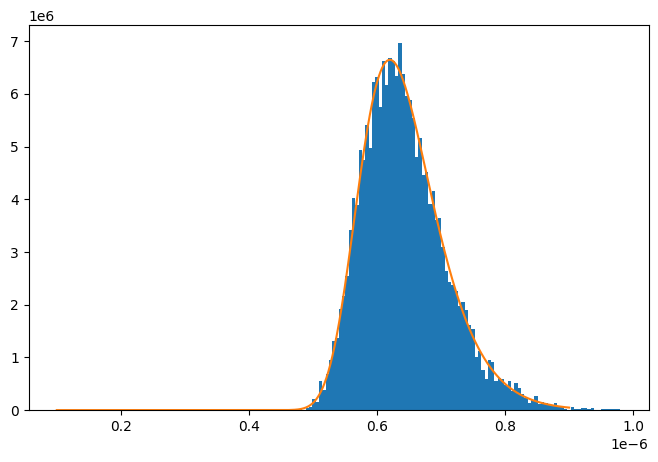

In [30]:
# x = np.linspace(2e-7,5e-7, 1001)
x = np.linspace(1e-7,9e-7, 1001)

ray_cdf = (1-np.exp(-(x**2)/tau_60f)) ** Nsamp
ray_pdf = np.gradient(ray_cdf, x[1]-x[0])
# ray_pdf = ray_pdf/np.trapz(ray_pdf)

N = 10000

lots_of_noise = rng.multivariate_normal([0,0],np.eye(2)*tau_60f/2, N*Nsamp)
lots_of_noise = lots_of_noise[:,0] + 1j * lots_of_noise[:,1]
lots_of_noise = lots_of_noise.reshape(N, Nsamp)
lots_of_noise = np.max(abs(lots_of_noise),axis=1)


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()

hist = ax.hist(lots_of_noise,bins=100, density=True)
ax.plot(x,  ray_pdf);
# ax.set_xlim(2.5e-7, 4.5e-7)


[3.16227766e-06]


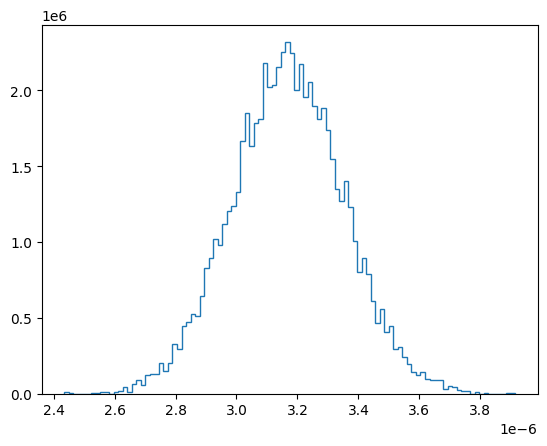

In [31]:
N = 10000
scale_factor = 0.66

# peaks = np.array(
#     [5e-7-1j*5e-7,
#      3e-7+1j*3e-7,
#      3e-7-1j*3e-7,
#      2e-7+1j*2e-7]) * scale_factor
# peak_inds = np.array([2000, 2500, 3000, 3500])

# peaks = np.array(
#     [5e-7-1j*5e-7,
#      ]) * scale_factor

# peak_inds = np.array([2500])   

peaks = np.array(
[0.03e-4 + 1j*0.01e-4])




peak_inds = np.array([50])

print(np.abs(peaks))

lots_of_noise = rng.multivariate_normal([0,0],np.eye(2)*tau_60f/2, N*Nsamp)
lots_of_noise = lots_of_noise[:,0] + 1j * lots_of_noise[:,1]
lots_of_noise = lots_of_noise.reshape(N, Nsamp)
noise_maxima = np.max(abs(lots_of_noise),axis=1)

lots_of_noise[:, peak_inds] += peaks
signal_maxima = np.max(abs(lots_of_noise),axis=1)

plt.figure()
plt.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')
plt.show()


250


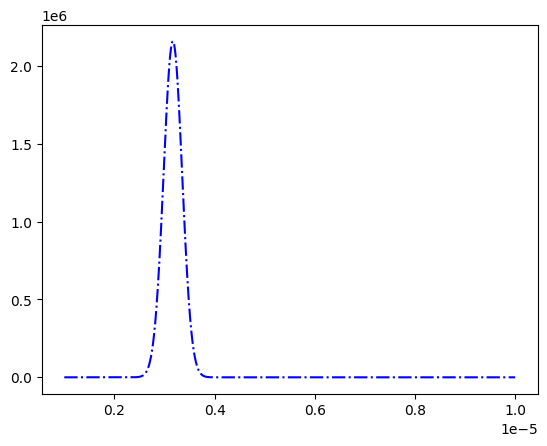

In [32]:
# y = np.linspace(1e-7, 9e-7, 2001)

y = np.linspace(1e-6, 10e-6, 20001)


# y = np.linspace(4.4e-6, 5e-6, 2001)



# rice_pdf1 = 2*(y / tau_60f) * np.exp(-(y**2 + abs(peaks[0])**2)/(1*tau_60f))*special.i0(2*y*abs(peaks[0])/ tau_60f)
rice_pdf2 = scipy.stats.rice.pdf(y, abs(peaks[0])/np.sqrt(tau_60f/2), scale=np.sqrt(tau_60f/2))

# plt.plot(y, rice_pdf1, color='red')
plt.plot(y, rice_pdf2, ls='-.', color='blue')

# plt.xlim(1e-7, 9e-7)
# plt.ylim(0, 2.5e7)

rice_cdf = np.ones(20001)
for peak in peaks:
    rice_cdf *= scipy.stats.rice.cdf(y, abs(peak)/np.sqrt(tau_60f/2), scale=np.sqrt(tau_60f/2))
    
signal_cdf = rice_cdf * (1-np.exp(-(y**2)/tau_60f)) ** (Nsamp-peaks.size)

signal_pdf = np.gradient(signal_cdf, y[1]-y[0])

print(Nsamp)

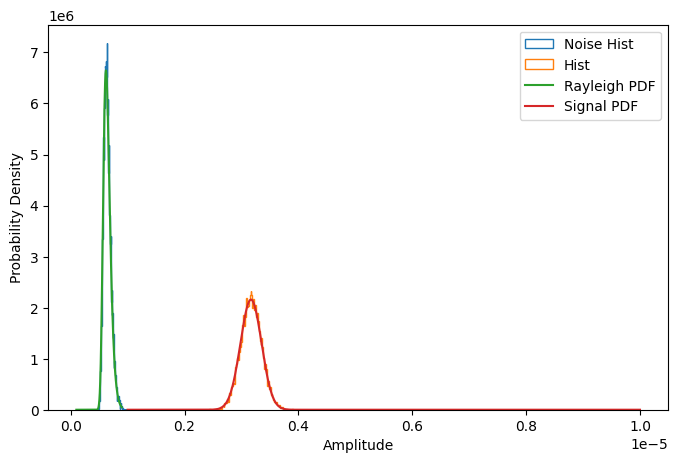

In [33]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)

hist = ax.hist(noise_maxima, bins=100, density=True, histtype='step', label='Noise Hist' )
hist = ax.hist(signal_maxima, bins=100, density=True, histtype='step', label='Hist')

ax.plot(x, ray_pdf, label='Rayleigh PDF')
ax.plot(y, signal_pdf, label = 'Signal PDF')

ax.set_xlabel('Amplitude')
ax.set_ylabel('Probability Density')

# ax.set_xlim(0.003, 0.0032)

ax.legend();